## Финальный проект специализации

В ноутбуке рассмотрен проект на тему: "Идентификация интернет пользователей"

Целью проекта является получение наилучших оценок в соревновании: [Catch Me If You Can](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) на сайте  [kaggle.com](https://www.kaggle.com)

**Данные:**

В обучающей выборке **train_sessions.csv** содержится информация о сайтах и времени их посещения, а также признак **target**, указывающий на то, что сессия принадлежит некой Элис.

**Задача:** 

Сделать прогнозы для сессий в тестовой выборке **test_sessions.csv** и определить, принадлежат ли они Элис.

Метрикой соревнования, учитываемой на Leaderboard является **ROC AUC** - площадь под ROC-кривой, которая показывает зависимость TPR(true positive rate) от FPR(false positive rate). [Wiki](http://www.machinelearning.ru/wiki/index.php?title=ROC-кривая) 

In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, TimeSeriesSplit

In [4]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

## 1. Подготовка данных

In [7]:
#Путь к данным
PATH_TO_DATA = ''

In [8]:
#Загрузим данные в Dataframe 
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

In [9]:
#Проверим размеры тестовых и обучающих выборок
print (train_df.shape, test_df.shape)

(253561, 21) (82797, 20)


In [17]:
#Рассмотрим структуру предоставленных данных
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


Как мы видим, каждая сессия содержит уникальный идентификатор сайта site_id и время его посещения. Некоторые сессии содержат пропуски NaN, поэтому при обработке данных мы должны их заполнить, например нулями.

Кроме этого сессии не упорядочены по времени начала **time1**. Необходимо удостовериться в том, что мы не нарушим временные ограничения во время обучения или кросс-валидации - к примеру не обучимся на будущем!

In [18]:
# Упорядочим train по времени и посмотрим на первую и последнюю строку
train_df = train_df.sort_values(by='time1')
train_df.iloc[[0, -1]]

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
204762,222,2014-04-30 23:39:53,3346.0,2014-04-30 23:39:59,3346.0,2014-04-30 23:40:00,3359.0,2014-04-30 23:40:05,55.0,2014-04-30 23:40:05,...,2014-04-30 23:40:05,3346.0,2014-04-30 23:40:05,NaN,NaN,NaN,NaN,NaN,NaN,0


In [19]:
# Упорядочим test по времени и посмотрим на первую и последнюю строку 
test_df_sorted = test_df
test_df_sorted = test_df_sorted.sort_values(by='time1')
test_df_sorted.iloc[[0, -1]]

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
65540,21,2014-05-01 17:14:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60141,56,2014-12-05 23:26:53,55.0,2014-12-05 23:26:53,56.0,2014-12-05 23:56:23,55.0,2014-12-05 23:56:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Мы получили упорядоченные по времени тестовую и обучающую выборки и убедились в том, что они строго разделены по времени: время начала теста больше, чем последняя обучающая сессия. 

Признаки *site1*, ..., *site10* не имеют смысла как признаки в задаче классификации. Воспользуемся идеей мешка слов из анализа текстов. Создадим новые матрицы, в которых строкам будут соответствовать сессии из 10 сайтов, а столбцам – индексы сайтов. На пересечении строки $i$ и столбца $j$ будет стоять число $n_{ij}$ – cколько раз сайт $j$ встретился в сессии номер $i$. Делать это будем с помощью разреженных матриц Scipy – [csr_matrix](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.html).

In [20]:
# Создадим вспомогательную функцию csr_matrix_arrays, которая на основе полученного массива X_list, создает
# массивы data, row, column и размеры csr-матрицы, которые далее передаются в функцию генерации  
# csr_matrix((data, (row, column)), shape=(shape_x, shape_y))
# Так как сайт с индексом 0 нас не интересует, то нулевой столбец разреженной матрицы не создается.
def csr_matrix_arrays(X_list):
    from collections import Counter
    row = []
    column = []
    data = []
    for idx, line in enumerate(X_list):
        for i,j in Counter(line).iteritems():
            # Фильтруем сайт с индексом 0
            if i != 0: 
                column.append(i-1) # Из-за отсутствия 0го сайта смещаем индекс на 1 влево 
                data.append(j)
                row.append(idx)
                
    shape_x = len(X_list)            
    shape_y = len(set([item for line in X_list for item in line]))-1
    return data, row, column, shape_x, shape_y

In [37]:
#Объединяем train и test выборки для создания csr-матрицы, заполняем NaN нулями
train_test_df = pd.concat([train_df, test_df], sort=False)
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
train_test_df_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [186]:
#Создаем csr-матрицу
data, row, column, shape_x, shape_y = csr_matrix_arrays(train_test_df_sites.values)
train_test_sparse = csr_matrix((data, (row, column)), shape=(shape_x, shape_y))
#Снова разбиваем на train и test
X_train_sparse = train_test_sparse[:train_df.shape[0]][:]
X_test_sparse = train_test_sparse[train_df.shape[0]:][:]
y = train_df['target'].astype('int').values

In [42]:
#Посмотрим на размеры получившихся матриц
print (X_train_sparse.shape[0], X_train_sparse.shape[1], X_test_sparse.shape[0], X_test_sparse.shape[1])

253561 48371 82797 48371


In [43]:
#Загрузим предоставленный в соревновании словарь соответствий имен сайтов и site_id и посмотрим на его размер
with open(os.path.join(PATH_TO_DATA,'site_dic.pkl'), 'rb') as site_freq_pkl:
        dictionary = pickle.load(site_freq_pkl)
len(dictionary)      

48371

Как видно, количество столбцов в csr-матрице в точности равно размеру словаря, что соответствует логике построения матрицы

## 2. Выбор стратегии кросс-валидации

В качестве эксперимента давайте рассмотрим два варианта кросс-валидации: 
 - StratifiedKFold с разбиением на 3 части
 - TimeSeriesSplit с разбиением на 10 частей. Смысл заключается в том, что обучающая часть fold всегда берется из ранних по времени элементов, а тестовая сразу за ней. Для массива [1 2 3 4 5 6] разбиение на 5 fold будет таким:
    - fold 1 : training [1], test [2]
    - fold 2 : training [1 2], test [3]
    - fold 3 : training [1 2 3], test [4]
    - fold 4 : training [1 2 3 4], test [5]
    - fold 5 : training [1 2 3 4 5], test [6]

Выбирая разбиение TimeSeriesSplit мы интуитивно исходим из того, что предпочтения пользователя со временем меняются и нам необходимо учитывать это во время обучения. Кроме этого кажется странным предсказывать прошлое по будущим сессиям.

Далее мы будем рассматривать различные варианты построения моделей и вычислять соответствующие значения ROC AUC на кросс-валидации по обоим типам. По результатам, показанным на leaderboard, можно будет понять какая стратегия кросс-валидации больше подходит для оценки конечного результата. 

In [181]:
# Создаем разбиение
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)
time_split = TimeSeriesSplit(n_splits=10)

In [182]:
# Построим логистическую регрессию со значениями по умолчанию
logit = LogisticRegression(C=1, random_state=17)

In [46]:
%%time
# Значение ROC AUC при StratifiedKFold разбиении
cv_skf_scores = cross_val_score(logit, X_train_sparse, y, cv=skf, scoring='roc_auc', n_jobs=-1)
print("CV_skf mean: {}, CV_skf std: {}".format(cv_skf_scores.mean(), cv_skf_scores.std()))

CV_skf mean: 0.961978868196, CV_skf std: 0.0011455988543
CPU times: user 291 ms, sys: 86.2 ms, total: 377 ms
Wall time: 5.33 s


In [47]:
%%time
# Значение ROC AUC при TimeSeriesSplit разбиении
cv_time_scores = cross_val_score(logit, X_train_sparse, y, cv=time_split, scoring='roc_auc', n_jobs=-1)
print ("CV_time_split mean: {}, CV_time_split std: {}".format(cv_time_scores.mean(), cv_time_scores.std()))

CV_time_split mean: 0.865794111549, CV_time_split std: 0.0749364223996
CPU times: user 573 ms, sys: 119 ms, total: 692 ms
Wall time: 12.6 s


In [48]:
# Обучаем модель и делаем submission
logit.fit(X_train_sparse, y)
logit_pred = logit.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(logit_pred, 'submission_logit.csv')
# LB = 0.90812

Попробуем подобрать параметры С, penalty логистической регрессии с помощью GridSearchCV

In [184]:
params = {
    'C': np.logspace(-2, 2, 10),
    'penalty': ['l1','l2']
}

In [81]:
%%time
logit_grid_searcher_skf = GridSearchCV(estimator=logit, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=skf)
logit_grid_searcher_skf.fit(X_train_sparse, y)
print(logit_grid_searcher_skf.best_score_, logit_grid_searcher_skf.best_params_)

0.9622912753750311 {'penalty': 'l2', 'C': 1.6681005372000592}
CPU times: user 15.9 s, sys: 790 ms, total: 16.7 s
Wall time: 5min 57s


In [52]:
%%time
logit_grid_searcher_time = GridSearchCV(estimator=logit, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=time_split)
logit_grid_searcher_time.fit(X_train_sparse, y)
print(logit_grid_searcher_time.best_score_, logit_grid_searcher_time.best_params_)

0.8656996471239852 {'penalty': 'l2', 'C': 0.5994842503189409}
CPU times: user 17.7 s, sys: 1.21 s, total: 18.9 s
Wall time: 12min 58s


GridSearchCV при кросс-валидации подобрал параметры C, penalty отличные от default, однако значения CV не сильно отличаются от начальных.
Попробуем сделать предсказания и посмотреть на характер зависимости значений метрики на Leaderboard от CV value

In [53]:
logit_skf_pred = logit_grid_searcher_skf.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(logit_skf_pred, 'submission_logit_skf.csv')
# LB = 0.90556 Результат даже немного ухудшился

In [54]:
logit_time_pred = logit_grid_searcher_time.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(logit_time_pred, 'submission_logit_time.csv')
# LB = 0.91044 Результат улучшился

## 3. Построение новых признаков

Построим дополнительные признаки:
- unique sites - количество уникальных сайтов в сессии
- start day - день недели начала сессии
- start hour - час начала сессии
- start month - месяц начала сессии
- seconds - продолжительность сессии в секундах
- minutes - продолжительность сессии в минутах 

In [138]:
%%time
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

X_add = train_test_df[times].apply(pd.to_datetime)

X_add['start day'] = X_add['time1'].apply(lambda x: x.dayofweek)
X_add['start hour'] = X_add['time1'].apply(lambda x: x.hour)
X_add['start month'] = X_add['time1'].apply(lambda x: x.month)

X_add['unique sites'] = train_test_df[sites].apply(pd.Series.nunique, axis=1)

X_add['min'] = X_add[times].min(axis=1)
X_add['max'] = X_add[times].max(axis=1)
X_add['seconds'] = ((X_add['max'] - X_add['min']) / np.timedelta64(1, 's'))
X_add['minutes'] = ((X_add['max'] - X_add['min']) / np.timedelta64(1, 'm')).round(2)
X_add.drop(['min','max'], inplace=True, axis=1)
X_add.drop(times, inplace=True, axis=1)

data = X_add # сохраним ссылку на X_add в data

CPU times: user 51.9 s, sys: 584 ms, total: 52.5 s
Wall time: 50.5 s


In [140]:
features_cat = ['start day', 'start hour', 'start month']
features_scale = ['unique sites', 'seconds', 'minutes']

In [141]:
# Произведем преобразование категориальных признаков 
X_add = pd.get_dummies(X_add, columns=features_cat)

In [142]:
# Произведем нормирование числовых признаков
X_add[features_scale] = StandardScaler().fit_transform(X_add[features_scale])

In [143]:
# Посмотрим на получившийся dataframe
X_add.head()

,unique sites,seconds,minutes,start day_0,start day_1,start day_2,start day_3,start day_4,start day_5,start day_6,...,start month_3,start month_4,start month_5,start month_6,start month_7,start month_8,start month_9,start month_10,start month_11,start month_12
session_id,,,,,,,,,,,,,,,,,,,,,
21669,-1.401301,-0.468611,-0.468613,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
54843,-1.401301,5.622634,5.623311,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
77292,0.177483,-0.454969,-0.454288,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
114021,-0.217213,-0.458380,-0.458381,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
146670,0.177483,-0.461790,-0.462474,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [146]:
# Сохраним получившиеся признаки
with open(os.path.join(PATH_TO_DATA, 
                       'Alice_new_features.pkl'), 'wb') as new_features_pkl:
    pickle.dump(X_add, new_features_pkl, 
                protocol=2)

In [71]:
# Добавим признаки в обучающую и тестовую выборки
from scipy.sparse import hstack
X_train = hstack((X_train_sparse, X_add.values[:train_df.shape[0]]))
X_test = hstack((X_test_sparse, X_add.values[train_df.shape[0]:]))

**Произведем подбор параметров логистической регрессии для получившегося набора признаков**

In [73]:
# SKF кросс-валидация
%%time
logit_grid_searcher_skf_new_fe = GridSearchCV(estimator=logit, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=skf)
logit_grid_searcher_skf_new_fe.fit(X_train, y)
print(logit_grid_searcher_skf_new_fe.best_score_, logit_grid_searcher_skf_new_fe.best_params_)

0.9891516435415935 {'penalty': 'l2', 'C': 4.6415888336127775}
CPU times: user 20.1 s, sys: 963 ms, total: 21.1 s
Wall time: 17min 53s


In [74]:
# TimeSplit кросс-валидация
%%time
logit_grid_searcher_time_new_fe = GridSearchCV(estimator=logit, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=time_split)
logit_grid_searcher_time_new_fe.fit(X_train, y)
print(logit_grid_searcher_time_new_fe.best_score_, logit_grid_searcher_time_new_fe.best_params_)

0.9168446111393702 {'penalty': 'l2', 'C': 1.6681005372000592}
CPU times: user 29.3 s, sys: 1.84 s, total: 31.1 s
Wall time: 41min 29s


Значения ROC AUC на CV увеличились в обоих случаях! Делаем предположение, что и результат на Leaderboard вырастет. 

**Сделаем предсказания и submission**

In [75]:
logit_skf_new_fe_pred = logit_grid_searcher_skf_new_fe.predict_proba(X_test)[:, 1]
write_to_submission_file(logit_skf_new_fe_pred, 'submission_logit_skf_new_fe.csv')
# LB = 0.93971 Результат улучшился

In [76]:
logit_time_new_fe_pred = logit_grid_searcher_time_new_fe.predict_proba(X_test)[:, 1]
write_to_submission_file(logit_time_new_fe_pred, 'submission_logit_time_new_fe.csv')
# LB = 0.94400 Результат улучшился

In [82]:
# Поместим получившиеся значения CV и Leaderboard в массив
cv_skf = [cv_skf_scores.mean(), logit_grid_searcher_skf.best_score_, logit_grid_searcher_skf_new_fe.best_score_]
lb_skf = [0.90812, 0.90556, 0.93971]
cv_time = [cv_time_scores.mean(), logit_grid_searcher_time.best_score_, logit_grid_searcher_time_new_fe.best_score_ ]
lb_time = [0.90812, 0.91044, 0.94400]

In [6]:
print ('cv_skf:', cv_skf)
print ('lb_skf:', lb_skf)
print ('cv_time:', cv_time)
print ('lb_time:', lb_time)


cv_skf: [0.961978868196006, 0.9622912753750311, 0.9891516435415935]
lb_skf: [0.90812, 0.90556, 0.93971]
cv_time: [0.8657941115491294, 0.8656996471239852, 0.9168446111393702]
lb_time: [0.90812, 0.91044, 0.944]


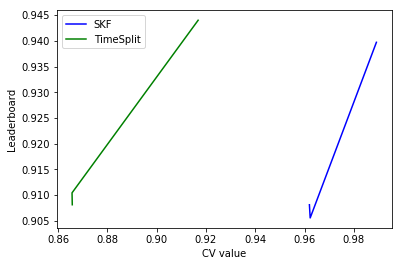

In [7]:
#  Начертим график зависимости значения ROC AUC на LB от значения на кросс-валидации
fig, ax = plt.subplots()
ax.plot(cv_skf, lb_skf, 'b', label='SKF')
ax.plot(cv_time, lb_time, 'g', label='TimeSplit')
ax.set_xlabel('CV value')
ax.set_ylabel('Leaderboard')
ax.legend()
plt.show()

**Выводы:**

 - На обоих графиках мы видим возрастающую функцию, значит результат на Leaderboard тем лучше, чем выше значение на кросс-валидации.
 - Добавление новых признаков дает улучшение результата

## 4. Применение TF-IDF

Попробуем поэкспериментировать с TF-IDF. Идея заключается в том, что значения site_id в сессии мы можем принять за слова и в этом случае сессии будут являться последовательностью слов. Применим к ним TfidfVectorizer с параметром n-gram = (1,3), то есть TfidfVectorizer будет рассматривать последовательности сайтов длиной 1,2 и 3.

In [173]:
# Заменяем NaN на 0 и объединяем все site_id в одну последовательность с разделителем в виде пробела
tf_idf = train_test_df[sites].fillna(0).astype('int')
tf_idf['words'] = tf_idf[sites].astype(np.str).apply(' '.join, axis=1)

In [174]:
words = TfidfVectorizer(max_features=50000, ngram_range=(1, 3)).fit_transform(tf_idf['words'])
tf_idf.drop(['words'], inplace=True, axis=1)

In [175]:
# Создаем тестовую и обучающую выборки
X_tf_idf_train_sparse = words[:train_df.shape[0]]
X_tf_idf_test_sparse = words[train_df.shape[0]:]

In [178]:
# Добавляем новые признаки
X_tf_idf_train = hstack((X_tf_idf_train_sparse, X_add.values[:train_df.shape[0]]))
X_tf_idf_test = hstack((X_tf_idf_test_sparse, X_add.values[train_df.shape[0]:]))

In [144]:
#X_tf_idf_train.shape

(253561, 50039)

**Подбираем параметры**

In [145]:
%%time
logit_grid_searcher_skf_new_fe_tf_idf = GridSearchCV(estimator=logit, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=skf)
logit_grid_searcher_skf_new_fe_tf_idf.fit(X_tf_idf_train, y)
print(logit_grid_searcher_skf_new_fe_tf_idf.best_score_, logit_grid_searcher_skf_new_fe_tf_idf.best_params_)

0.9879776826070505 {'penalty': 'l2', 'C': 12.915496650148826}
CPU times: user 24.2 s, sys: 891 ms, total: 25.1 s
Wall time: 15min 48s


In [146]:
%%time
logit_grid_searcher_time_new_fe_tf_idf = GridSearchCV(estimator=logit, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=time_split)
logit_grid_searcher_time_new_fe_tf_idf.fit(X_tf_idf_train, y)
print(logit_grid_searcher_time_new_fe_tf_idf.best_score_, logit_grid_searcher_time_new_fe_tf_idf.best_params_)

0.9120791302303046 {'penalty': 'l2', 'C': 4.6415888336127775}
CPU times: user 37.9 s, sys: 2.05 s, total: 39.9 s
Wall time: 39min 6s


**Делаем предсказания и submission**

In [147]:
logit_skf_new_fe_tf_idf_pred = logit_grid_searcher_skf_new_fe_tf_idf.predict_proba(X_tf_idf_test)[:, 1]
write_to_submission_file(logit_skf_new_fe_tf_idf_pred, 'submission_logit_skf_new_fe_tf_idf.csv')
# LB = 0.94734 Улучшение!

In [148]:
logit_time_new_fe_tf_idf_pred = logit_grid_searcher_time_new_fe_tf_idf.predict_proba(X_tf_idf_test)[:, 1]
write_to_submission_file(logit_time_new_fe_tf_idf_pred, 'submission_logit_time_new_fe_tf_idf.csv')
# LB = 0.94987 Новый рекорд!

In [11]:
# Поместим результаты в массив
tf_idf_lb = [0.94734, 0.94987]
tf_idf_cv = [logit_grid_searcher_skf_new_fe_tf_idf.best_score_, logit_grid_searcher_time_new_fe_tf_idf.best_score_]

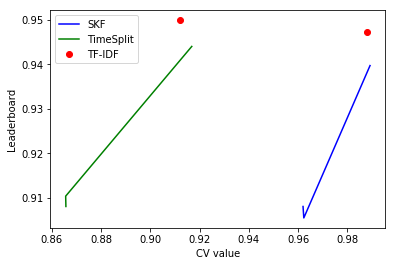

In [12]:
# Поместим получившиеся значения ROC AUC на CV и LB на предыдущий график 
fig, ax = plt.subplots()
ax.plot(cv_skf, lb_skf, 'b', label='SKF')
ax.plot(cv_time, lb_time, 'g', label='TimeSplit')
ax.set_xlabel('CV value')
ax.set_ylabel('Leaderboard')
ax.plot(tf_idf_cv, tf_idf_lb, 'ro', label='TF-IDF')
ax.legend()
plt.show()

**Выводы:**

 - При применении TF_IDF даже при меньших значениях метрики на кросс-валидации результат на Leaderboard лучше, чем Sparse matrix (bag of words)
 - Подбор параметров при TimeSplit кросс-валидации дает более высокий результат, чем при SKF
 - Но в любом случае рост значения на кросс-валидации обеспечивает улучшение на Leaderboard, поэтому оба варианта подходят для предварительной оценки качества модели.
 
**Далее будем применять TF-IDF и TimeSplit кросс-валидацию для оценки качества получившихся моделей**

## 5. Визуальный анализ и дополнительные признаки

Изучим получившиеся признаки более подробно

In [150]:
data['target'] = train_test_df['target']

**Посмотрим на распределение признаков start day, start hour, start month**

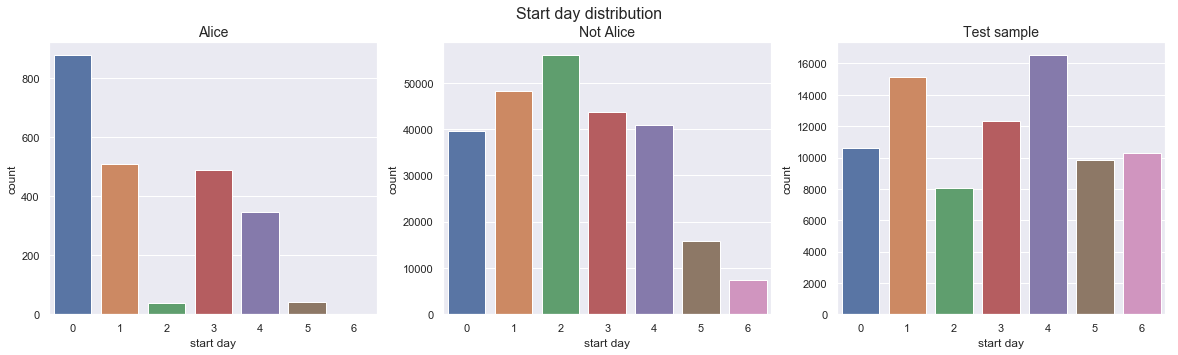

In [151]:
# Start day
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
fig.suptitle("Start day distribution", fontsize=16)
sns.countplot(x="start day", data=data[data.target==1][:idx], ax=axes[0])
axes[0].set_title("Alice", fontsize=14)
sns.countplot(x="start day", data=data[data.target==0][:idx], ax=axes[1])
axes[1].set_title("Not Alice", fontsize=14)
sns.countplot(x="start day", data=data[idx:], ax=axes[2]); 
axes[2].set_title("Test sample", fontsize=14)
plt.show()

**Alice активно пользуется интернетом в понедельник, вторник, четверг и пятницу**

Можно попробовать создать новые признаки, которые это будут учитывать. Например:

 - favorite days - признак равен 1, если start day in [0,1,3,4]
 - wednesday - признак равен 1, если start day = 2
 - weekend - признак равен 1, если start day in [5,6]

In [152]:
data['favorite days'] = data['start day'].apply(lambda x: x in [0,1,3,4]).astype('int')
data['wednesday'] = data['start day'].apply(lambda x: x == 2).astype('int')
data['weekend'] = data['start day'].apply(lambda x: x in [5,6]).astype('int')

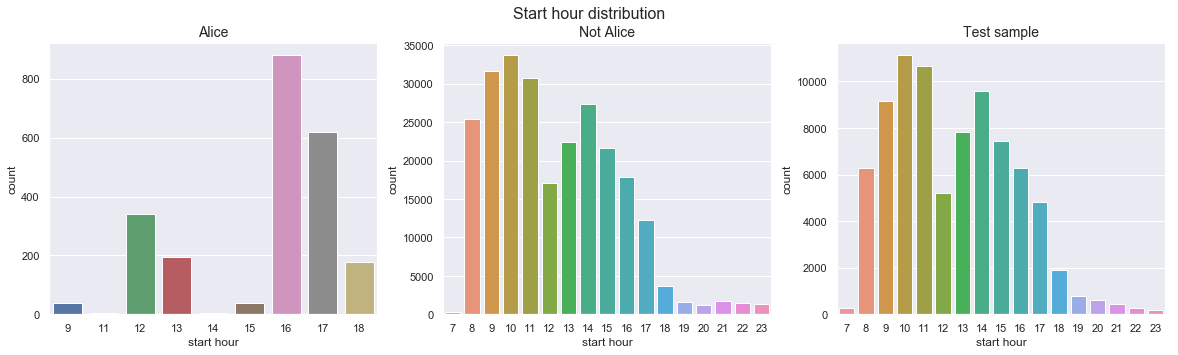

In [153]:
# Start hour
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
fig.suptitle("Start hour distribution", fontsize=16)
sns.countplot(x="start hour", data=data[data.target==1][:idx], ax=axes[0])
axes[0].set_title("Alice", fontsize=14)
sns.countplot(x="start hour", data=data[data.target==0][:idx], ax=axes[1])
axes[1].set_title("Not Alice", fontsize=14)
sns.countplot(x="start hour", data=data[idx:], ax=axes[2]); 
axes[2].set_title("Test sample", fontsize=14)
plt.show()

**Здесь также можно выделить характерные для Alice часы**

Попробуем следующие признаки:
 - morning (с 7 до 11)
 - day (с 12 до 15)
 - evening (с 16 до 18)
 - night (с 19 до 23)

In [154]:
data['morning'] = data['start hour'].apply(lambda x: (x >= 7) & (x < 12)).astype('int')
data['day'] = data['start hour'].apply(lambda x: (x >= 12) & (x < 16)).astype('int')
data['evening'] = data['start hour'].apply(lambda x: (x >= 16) & (x < 19)).astype('int')
data['night'] = data['start hour'].apply(lambda x: (x >= 19) & (x <= 23)).astype('int')

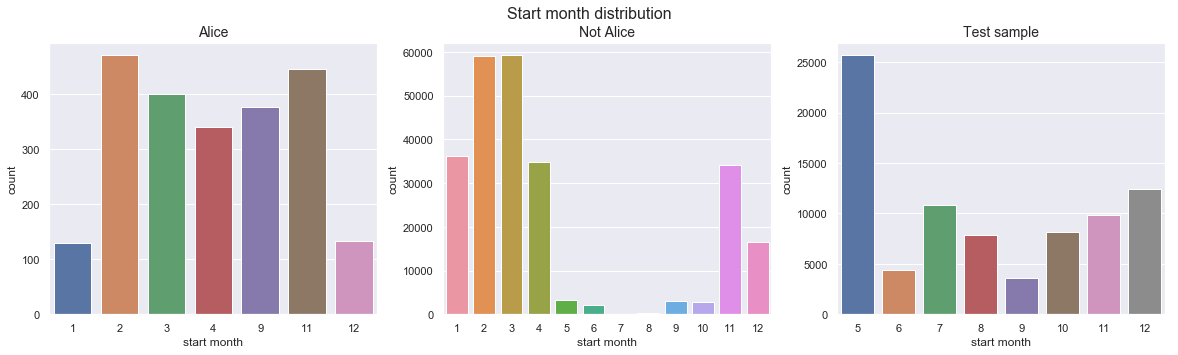

In [155]:
# Start month
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
fig.suptitle("Start month distribution", fontsize=16)
sns.countplot(x="start month", data=data[data.target==1][:idx], ax=axes[0])
axes[0].set_title("Alice", fontsize=14)
sns.countplot(x="start month", data=data[data.target==0][:idx], ax=axes[1])
axes[1].set_title("Not Alice", fontsize=14)
sns.countplot(x="start month", data=data[idx:], ax=axes[2]); 
axes[2].set_title("Test sample", fontsize=14)
plt.show()

**На представленном графике довольно сложно построить какие-то закономерности в поведении Alice. Возможно это связано с тем, что в признаке month смешиваются два года 2013 и 2014. Далее мы попробуем это проанализировать.**

Посмотрим на последний признак - число уникальных сайтов

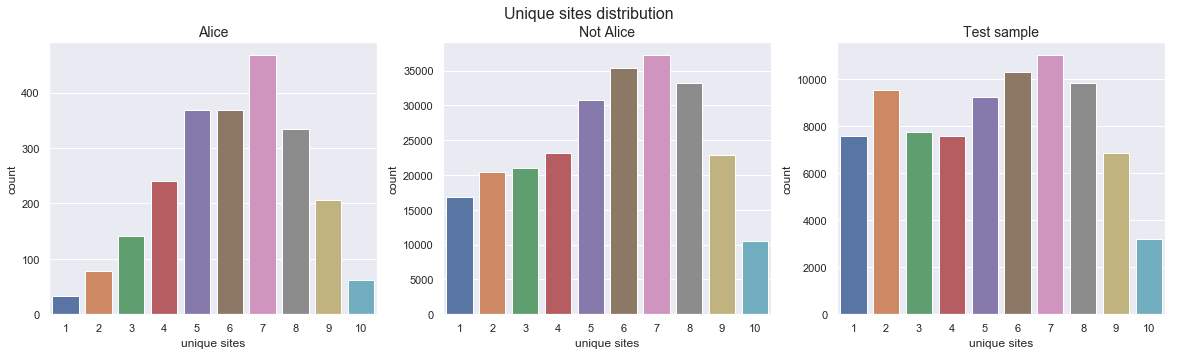

In [156]:
# Unique sites
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
fig.suptitle("Unique sites distribution", fontsize=16)
sns.countplot(x="unique sites", data=data[data.target==1][:idx], ax=axes[0])
axes[0].set_title("Alice", fontsize=14)
sns.countplot(x="unique sites", data=data[data.target==0][:idx], ax=axes[1])
axes[1].set_title("Not Alice", fontsize=14)
sns.countplot(x="unique sites", data=data[idx:], ax=axes[2]); 
axes[2].set_title("Test sample", fontsize=14)
plt.show()

**Особенности поведения Alice на этом признаке (unique sites) установить сложно, возможно признак бесполезен**

Посмотрим на распределения длины сессии для Alice и остальных пользователей

(-30, 300)

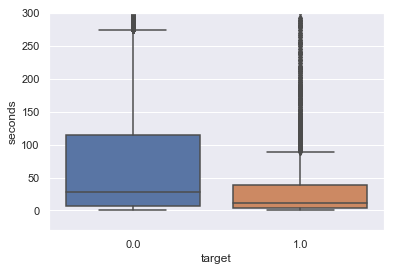

In [157]:
# Посмотрим на распределения длины сессии для Alice
sns.boxplot(x='target', y='seconds', data=data[:idx])
plt.ylim(-30,300)

**Длина сессии у Alice обычно короче, чем у других пользователей**

Можно попробовать признак:
    - short session, если длина в секундах меньше 50
    - long session, если длина больше 50

In [158]:
data['short session'] = data['seconds'].apply(lambda x: x < 50).astype('int')
data['long session'] = data['seconds'].apply(lambda x: x >= 50).astype('int')

**Рассмотрим признак month в разрезе лет**

In [159]:
data['start year'] = train_test_df['time1'].apply(pd.to_datetime).apply(lambda x: x.year)

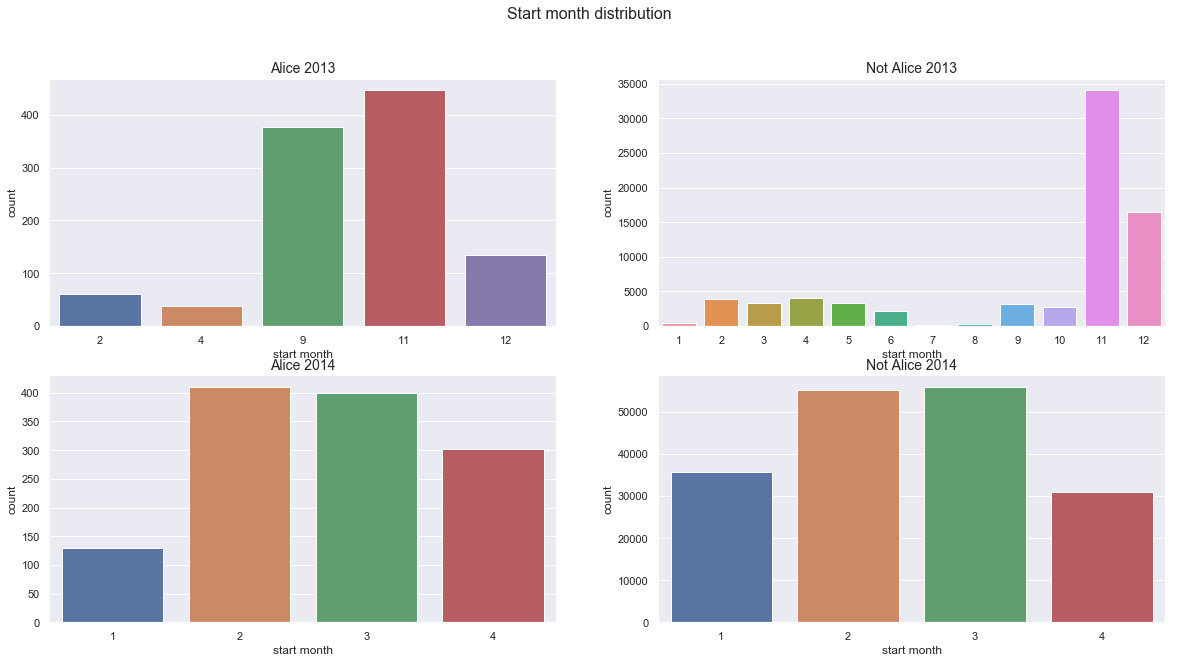

In [160]:
# Start month по годам
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
fig.suptitle("Start month distribution", fontsize=16)
sns.countplot(x="start month", data=data[(data.target==1) & (data['start year']==2013)][:idx], ax=axes[0][0])
axes[0][0].set_title("Alice 2013", fontsize=14)
sns.countplot(x="start month", data=data[(data.target==0) & (data['start year']==2013)][:idx], ax=axes[0][1])
axes[0][1].set_title("Not Alice 2013", fontsize=14)

sns.countplot(x="start month", data=data[(data.target==1) & (data['start year']==2014)][:idx], ax=axes[1][0])
axes[1][0].set_title("Alice 2014", fontsize=14)
sns.countplot(x="start month", data=data[(data.target==0) & (data['start year']==2014)][:idx], ax=axes[1][1])
axes[1][1].set_title("Not Alice 2014", fontsize=14)

plt.show()

**На графике видно, что поведение Alice зависит от года и на некоторых временных интервалах сильно отличается от остальных пользователей**

Попробуем построить и исследовать признак, который будет учитывать как месяц, так и год. Например **yyyymm = year*100+month**

In [161]:
data['yyyymm'] = train_test_df['time1'].apply(pd.to_datetime).apply(lambda x: x.year*100+x.month).astype('int')

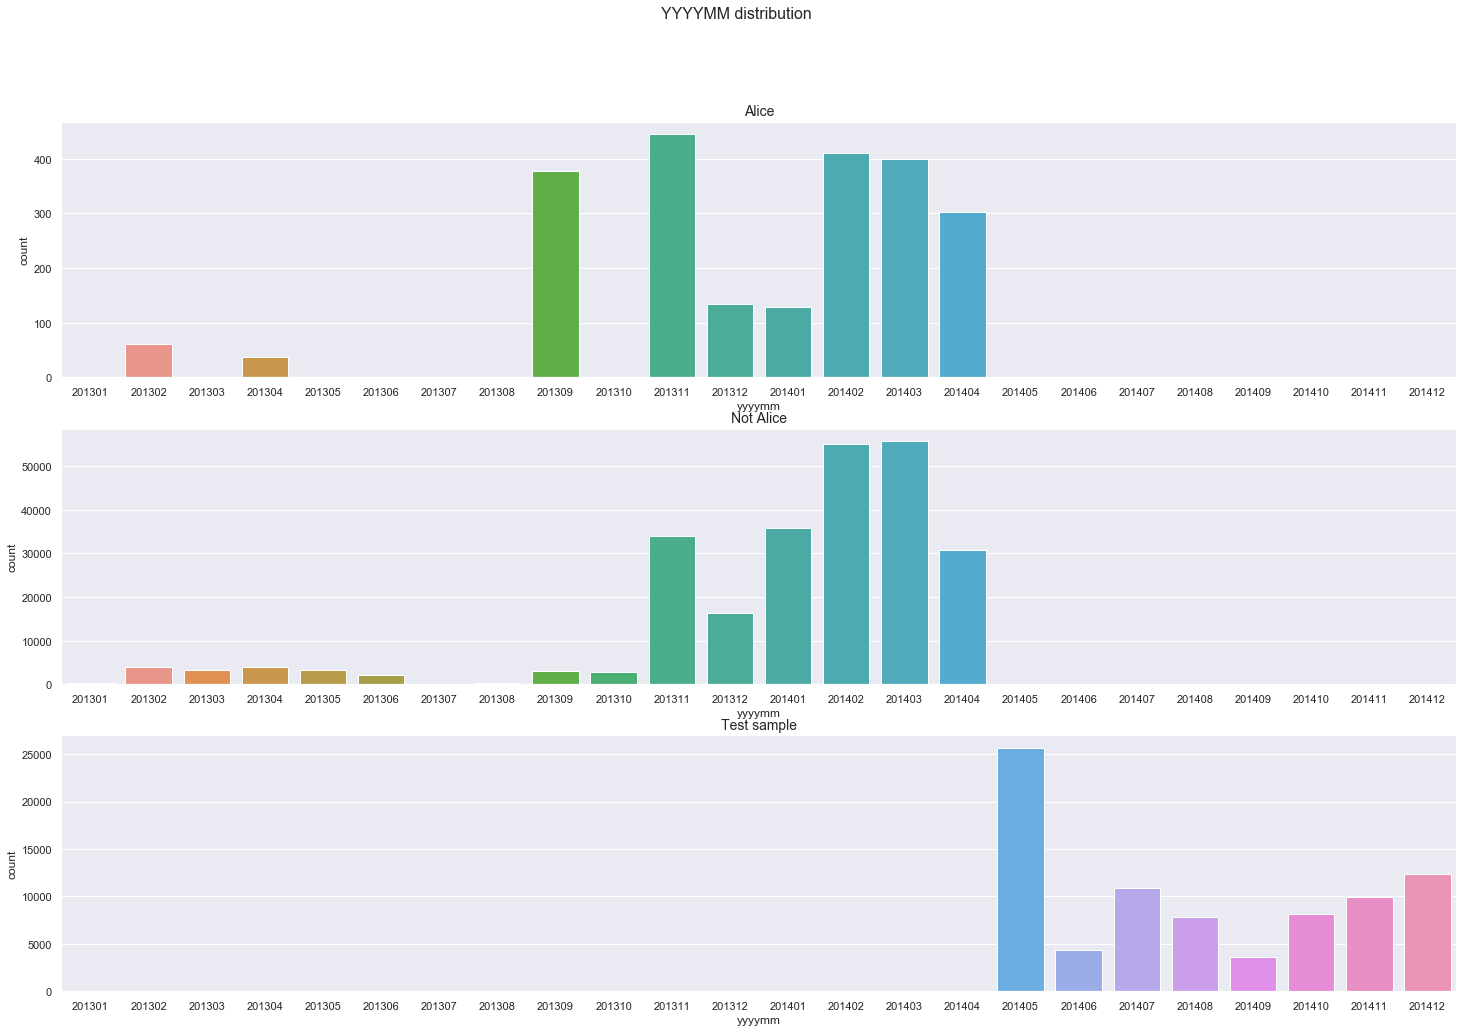

In [162]:
yyyymm = [int("{}{}".format(year, month)) for year in ['2013', '2014'] \
          for month in ['01','02','03','04','05','06','07','08','09','10','11','12']]
#print (yyyymm)
# YYYYMM feature
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(25,16))
fig.suptitle("YYYYMM distribution", fontsize=16)
sns.countplot(x="yyyymm", data=data[data.target==1][:idx], order=yyyymm, ax=axes[0])
axes[0].set_title("Alice", fontsize=14)
sns.countplot(x="yyyymm", data=data[data.target==0][:idx], order=yyyymm, ax=axes[1])
axes[1].set_title("Not Alice", fontsize=14)
sns.countplot(x="yyyymm", data=data[idx:], order=yyyymm, ax=axes[2]); 
axes[2].set_title("Test sample", fontsize=14)
plt.show()

**Из графика можно выделить три характерных интервала:**

 - до сентября 2013 поведение Alice практически не отличается от других
 - с сентября 2013 до января 2014 заметна разница
 - с февраля 2014 поведение Alice снова похоже на остальных пользователей
 
 
Можно было попробовать создать категориальный признак на основе временных интревалов, но мы попробуем оставить все как есть. Только произведем нормировку StandartScaler.

In [167]:
data.drop(['target'], inplace=True, axis=1)
data.head()

,start day,start hour,start month,unique sites,seconds,minutes,favorite days,wednesday,weekend,morning,day,evening,night,short session,long session,start year,yyyymm
session_id,,,,,,,,,,,,,,,,,
21669,5,8,1,2,0.0,0.00,0,0,1,1,0,0,0,1,0,2013,201301
54843,5,8,1,2,1786.0,29.77,0,0,1,1,0,0,0,0,1,2013,201301
77292,5,8,1,6,4.0,0.07,0,0,1,1,0,0,0,1,0,2013,201301
114021,5,8,1,5,3.0,0.05,0,0,1,1,0,0,0,1,0,2013,201301
146670,5,8,1,6,2.0,0.03,0,0,1,1,0,0,0,1,0,2013,201301


In [168]:
features_cat = ['start day', 'start hour', 'start month', 'start year']
features_scale = ['unique sites', 'seconds', 'minutes']

In [169]:
# Произведем преобразование категориальных признаков 
data = pd.get_dummies(data, columns=features_cat)
# Произведем нормирование числовых признаков
data[features_scale] = StandardScaler().fit_transform(data[features_scale])

In [171]:
data.head()

,unique sites,seconds,minutes,favorite days,wednesday,weekend,morning,day,evening,night,...,start month_5,start month_6,start month_7,start month_8,start month_9,start month_10,start month_11,start month_12,start year_2013,start year_2014
session_id,,,,,,,,,,,,,,,,,,,,,
21669,-1.401301,-0.468611,-0.468613,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
54843,-1.401301,5.622634,5.623311,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
77292,0.177483,-0.454969,-0.454288,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
114021,-0.217213,-0.458380,-0.458381,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
146670,0.177483,-0.461790,-0.462474,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [172]:
# Сохраним получившиеся признаки
with open(os.path.join(PATH_TO_DATA, 
                       'Alice_new_features_2.pkl'), 'wb') as new_features_2_pkl:
    pickle.dump(data, new_features_2_pkl, 
                protocol=2)

In [179]:
# Добавляем новые признаки в выборки
X_tf_idf_train = hstack((X_tf_idf_train_sparse, data.values[:train_df.shape[0]]))
X_tf_idf_test = hstack((X_tf_idf_test_sparse, data.values[train_df.shape[0]:]))

In [187]:
# Подбор параметров модели
%%time
logit_grid_searcher_final = GridSearchCV(estimator=logit, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=time_split)
logit_grid_searcher_final.fit(X_tf_idf_train, y)
print(logit_grid_searcher_final.best_score_, logit_grid_searcher_final.best_params_)

0.9088118509433656 {'penalty': 'l1', 'C': 1.6681005372000592}
CPU times: user 7min 45s, sys: 3.91 s, total: 7min 49s
Wall time: 1h 56min 44s


In [188]:
# Делаем предсказание и submission
logit_final_pred = logit_grid_searcher_final.predict_proba(X_tf_idf_test)[:, 1]
write_to_submission_file(logit_final_pred, 'submission_logit_final.csv')


**LB=0.95136** - максимальный результат!
[Скриншот результата](https://yadi.sk/i/WVZ0SM5u7j03IQ)

**Выводы:**

**Мы получили довольно неплохой результат на leaderboard соревнования. Что еще можно было сделать?**

 - попробовать применить SGDClassifier для увеличения быстродействия
 - попробовать перебором подобрать важные признаки, используя SGDClassifier
 - попробовать применить blending разных алгоритмов
 - попробовать обучить модель только на данных 2014 года, так как тестовая выборка содержит только 2014 год, а поведение Alice год от года отличается
 
**Построеные в данном соревновании модели могут применяться не только в детектировании незаконного проникновения в сетевые ресурсы, но и во многих других сферах связанных с взаимодействием интернет-ресурсов и людей. Рекомендации в интернет-магазинах, показ рекламы, подразумевают под собой как можно более точное определение целевой аудитории, и в этом нам могут помочь модели классификации, рассмотренные в данном проекте.**